<a href="https://colab.research.google.com/github/vshalisko/GEE/blob/main/Colab/Landsat_ANN_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Uso de ANN para clasificacion de Landsat

In [1]:
!pip install pyrsgis

Preparar el entorno

In [3]:
import ee
import geemap
import random
import math, glob, time
import numpy as np
from pyrsgis import raster, convert
from google.colab import drive

random.seed(2)

Conección con GEE

In [4]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize(project='ee-viacheslavs')

Lectura de capas de datos

In [6]:
punto_interes = ee.Geometry.Point([-103.76, 19.75])
fecha_inicio = '2015-03-01'
fecha_final = '2015-05-15'

print(punto_interes.getInfo())

# filtrado de datos Landsat potencialemtne adecuados
L8_collection = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2").filterBounds(punto_interes).filterDate(fecha_inicio, fecha_final).filter(ee.Filter.lessThan('CLOUD_COVER', 5))
print('Capas de datos filtrados:', L8_collection.size().getInfo())

# Cargar imagen de la colección (Landsat 8).
L8_image = L8_collection.first()

# Load builtup 2015 (res 100 m)
ghs_built_image = ee.Image('JRC/GHSL/P2023A/GHS_BUILT_S/2015')
built_2015_lr = ghs_built_image.select('built_surface')

# Load builtup 2015 (res 10 m)
built_2015_hr = ee.Image('DLR/WSF/WSF2015/v1')

# blackBackground = ee.Image(0);


{'type': 'Point', 'coordinates': [-103.76, 19.75]}
Capas de datos filtrados: 2


Visualizar capas de datos

In [8]:

Map = geemap.Map()
# Center the map and display the image.
Map.centerObject(punto_interes, 8)

# Parametros de visualizacion para Landsat 8
vizParams_L8 = {
  'bands': ['SR_B5', 'SR_B4', 'SR_B3'],
   'min': 5000,
   'max': 15000
  #'gamma': [0.95, 1.1, 1]
}
# Parametros de visualizacion para Builtup LR
vizBuiltup_LR = {
   'min': 0,
   'max': 1,
  'palette': ['white','black']
}
# Parametros de visualizacion para Builtup HR
vizBuiltup_HR = {
  min: 0,
  max: 255,
  'palette': ['white','black']
}

# Agregar capas
Map.addLayer(L8_image, vizParams_L8, 'Composición de falso color', True, 0.5)
Map.addLayer(built_2015_lr, vizBuiltup_LR, 'Builtup 2015 100m', True, 0.5)
Map.addLayer(built_2015_hr, vizBuiltup_HR, 'Builtup 2015 10m', True, 0.5)

# Presentar mapa
Map


Map(center=[19.75, -103.76], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

Conversión de datos en numpy array para el analisis

In [32]:
limites = [-103.65,-103.05, 20.43, 20.95]
pixel = 0.00026
alto = math.ceil((limites[3] - limites[2]) / pixel)
max_tile = 250000
print(alto)
ancho = math.ceil(max_tile / alto)
print(ancho)
incremento = ancho * pixel
print(incremento)

seq = list(np.arange(limites[0], limites[1], incremento))

segment_list = []
Map1 = geemap.Map()
# Center the map and display the image.
Map1.centerObject(punto_interes, 8)
for i in range(len(seq)-1):
  segment = ee.Geometry.Polygon(
        [[[seq[i], limites[3]],
          [seq[i], limites[2]],
          [seq[i+1], limites[2]],
          [seq[i+1], limites[3]]]], None, False)
  segment_list.append(segment)
  Map1.addLayer(segment, {'color': 'yellow'}, str(i), True, 0.5)
Map1
#print(segment_list)

2000
125
0.032499999999999994


Map(center=[19.75, -103.76], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

None
{'type': 'Projection', 'crs': 'EPSG:32613', 'transform': [30, 0, 552285, 0, -30, 2352915]}
Cero array (102, 79, 6)
First array (102, 124, 6)
Second array (102, 125, 6)
Full array (102, 328, 6)


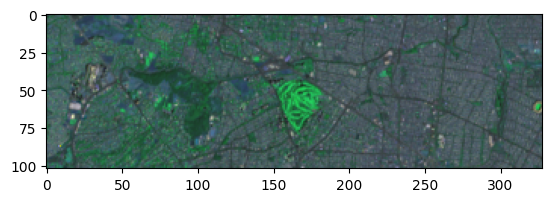

New array (1920, 130, 6)
New array (1921, 130, 6)


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 1920 and the array at index 1 has size 1921

In [34]:
bands_L8 = ['SR_B2','SR_B3','SR_B4','SR_B5','SR_B6','SR_B7']
bands_B = ['settlement']



def tile_to_numpy(image, rectangle, bands):
  ## extraccion de bandas en un region rectangular
  image_tile = image.sampleRectangle(region=rectangle,defaultValue=0)
  first_band = image_tile.get(bands[0])
  band_array_np = np.array(first_band.getInfo())
  band_array_np = np.expand_dims(band_array_np, 2)
  for b in bands[1:]:
    b_arr = image_tile.get(b)
    b_arr_np = np.array(b_arr.getInfo())
    b_arr_np = np.expand_dims(b_arr_np, 2)
    #print(b_arr_np.shape)
    #print(band_array_np.shape)
    band_array_np = np.concatenate((band_array_np, b_arr_np), 2)
  return band_array_np



image_meta = L8_image.getInfo()
imagename = image_meta.get('properties',{}).get('PRODUCT_ID')
print(imagename)

projection = L8_image.projection().getInfo();
print(projection)

#print(geemap.image_props(image).getInfo())

# definición de un region pequeño para el analisis
aoi0 = ee.Geometry.Polygon(
        [[[-103.42046006557397, 20.721686475573005],
          [-103.42046006557397, 20.694710560279958],
          [-103.39846006557397, 20.694710560279958],
          [-103.39846006557397, 20.721686475573005]]], None, False);
aoi1 = ee.Geometry.Polygon(
        [[[-103.39846006557397, 20.721686475573005],
          [-103.39846006557397, 20.694710560279958],
          [-103.36309782192163, 20.694710560279958],
          [-103.36309782192163, 20.721686475573005]]], None, False);
aoi2 = ee.Geometry.Polygon(
        [[[-103.36309782192163, 20.721686475573005],
          [-103.36309782192163, 20.694710560279958],
          [-103.32773557826929, 20.694710560279958],
          [-103.32773557826929, 20.721686475573005]]], None, False);

array0 = tile_to_numpy(L8_image, aoi0, bands_L8)
print("Cero array", array0.shape)
array1 = tile_to_numpy(L8_image, aoi1, bands_L8)
print("First array", array1.shape)
array2 = tile_to_numpy(L8_image, aoi2, bands_L8)
print("Second array", array2.shape)


array_full = np.concatenate((array0, array1, array2), 1)
print("Full array", array_full.shape)

import matplotlib.pyplot as plt

# Scale the data to [0, 255] to show as an RGB image.
rgb_img_test = (255*((array_full - 5000)/30000)).astype('uint8')
plt.imshow(rgb_img_test[:,:,2:5])
plt.show()

array_full_new = tile_to_numpy(L8_image, segment_list[0], bands_L8)
print("New array", array_full_new.shape)
for segment in segment_list[1:]:
  segment_new = tile_to_numpy(L8_image, segment, bands_L8)
  print("New array", segment_new.shape)
  array_full_new = np.concatenate((array_full_new, segment_new), 1)
print("Full array", array_full_new.shape)


{'type': 'Image', 'bands': [{'id': 'settlement', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 255}, 'crs': 'EPSG:32613', 'crs_transform': [30, 0, 552285, 0, -30, 2352915]}], 'version': 1641990115208687, 'id': 'DLR/WSF/WSF2015/v1', 'properties': {'date_range': [1420070400000, 1451606400000], 'period': 0, 'type_name': 'Image', 'keywords': ['landcover', 'landsat-derived', 'sentinel1-derived', 'settlement', 'urban'], 'system:time_end': 1451520000000, 'description': '<p>The World Settlement Footprint (WSF) 2015 is a 10m resolution binary mask\noutlining the extent of human settlements globally derived by means of\n2014-2015 multitemporal Landsat-8 and Sentinel-1 imagery (of which ~217,000 and\n~107,000 scenes have been processed, respectively).</p><p>The temporal dynamics of human settlements over time are\nsensibly different than those of all other non-settlement information classes.\nHence, given all the multitemporal images available over a region of interest\n

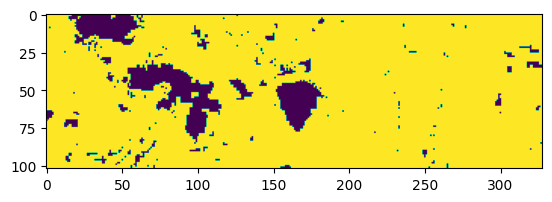

In [ ]:
## Resample
built_2015_hr_mean = built_2015_hr.reproject(projection.get('crs'), projection.get('transform'))

print(built_2015_hr_mean.getInfo())

#proj = ee.Projection('EPSG:4326').getInfo()
#built_2015_hr_mean = built_2015_hr.reproject(proj.get('crs'), None, 30)
#print(built_2015_hr_mean.getInfo())

Map1 = geemap.Map()
Map1.centerObject(punto_interes, 8)
Map1.addLayer(built_2015_hr_mean, vizBuiltup_HR, 'Builtup 2015 10m', True, 0.5)
Map1

arrayL1 = tile_to_numpy(built_2015_hr_mean, aoi0, bands_B)
print("Label array 2", arrayL1.shape)
arrayL2 = tile_to_numpy(built_2015_hr_mean, aoi1, bands_B)
print("Label array 2", arrayL2.shape)
arrayL3 = tile_to_numpy(built_2015_hr_mean, aoi2, bands_B)
print("Label array 3", arrayL3.shape)

array_labels = np.concatenate((arrayL1, arrayL2, arrayL3), 1)
print("Full labels array", array_labels.shape)

# Scale the data to [0, 255] to show as an RGB image.
B_img_test = (array_labels).astype('uint8')
plt.imshow(B_img_test[:,:,0])
plt.show()


In [ ]:
array_full_t = np.transpose(array_full, (2, 0, 1))
array_labels_t = np.transpose(array_labels, (2, 0, 1))
print(array_full_t.shape)
print(array_labels_t.shape)
x_features = convert.array_to_table(array_full_t)
y_labels = convert.array_to_table(array_labels_t)
#featuresHyderabad = changeDimension(featuresHyderabad)
nBands = x_features.shape[1]
#labelBangalore = (labelBangalore == 1).astype(int)

print(x_features.shape)
print(x_features)
print(y_labels.shape)
print(y_labels)

unique_values, occurrence_count = np.unique(y_labels, return_counts=True)
print(unique_values)
print(occurrence_count)

(6, 102, 328)
(1, 102, 328)
(33456, 6)
[[ 9357 10684 12931 17804 18460 16840]
 [ 9119 10732 13210 15202 17931 17136]
 [10058 10794 11812 14597 14941 14313]
 ...
 [ 9434 10024 10446 13821 13243 12324]
 [10319 10916 11821 14878 14932 13856]
 [11988 12709 13541 16119 15902 14938]]
(33456, 1)
[[255]
 [255]
 [255]
 ...
 [255]
 [255]
 [255]]
[  0 255]
[ 3324 30132]


In [ ]:
from sklearn.model_selection import train_test_split

# Normalise the data
y_labels = y_labels / 255
x_features = x_features / 32768

xTrain, xTest, yTrain, yTest = train_test_split(x_features, y_labels, test_size=0.4, random_state=42)

print(xTrain.shape)
print(yTrain.shape)

print(xTest.shape)
print(yTest.shape)

print(xTrain)
print(yTrain)

# Reshape the data
xTrain = xTrain.reshape((xTrain.shape[0], 1, xTrain.shape[1]))
xTest = xTest.reshape((xTest.shape[0], 1, xTest.shape[1]))

print(xTrain.shape, xTest.shape)

(20073, 6)
(20073, 1)
(13383, 6)
(13383, 1)
[[0.35079956 0.38021851 0.41516113 0.47119141 0.48477173 0.43170166]
 [0.34890747 0.37203979 0.41381836 0.46160889 0.47689819 0.43481445]
 [0.32714844 0.36761475 0.40979004 0.50744629 0.50933838 0.4725647 ]
 ...
 [0.35369873 0.38165283 0.41885376 0.46484375 0.48059082 0.44314575]
 [0.36843872 0.38381958 0.40368652 0.48980713 0.48718262 0.45324707]
 [0.32070923 0.3526001  0.39483643 0.45535278 0.46182251 0.41918945]]
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]
(20073, 1, 6) (13383, 1, 6)


Train neural network

In [ ]:
from tensorflow import keras

# Define the parameters of the model
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(1, nBands)),
    keras.layers.Dense(14, activation='relu'),
    keras.layers.Dense(2, activation='softmax')])

# Define the accuracy metrics and parameters
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Run the model
model.fit(xTrain, yTrain, epochs=5)

Epoch 1/5
628/628 [==============================] - 4s 5ms/step - loss: 0.3244 - accuracy: 0.8999
Epoch 2/5
628/628 [==============================] - 3s 5ms/step - loss: 0.2831 - accuracy: 0.8999
Epoch 3/5
628/628 [==============================] - 2s 3ms/step - loss: 0.2590 - accuracy: 0.9019
Epoch 4/5
628/628 [==============================] - 1s 2ms/step - loss: 0.2423 - accuracy: 0.9097
Epoch 5/5
628/628 [==============================] - 1s 2ms/step - loss: 0.2323 - accuracy: 0.9143


In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

# Predict for test data
yTestPredicted = model.predict(xTest)
yTestPredicted = yTestPredicted[:,1]

# Calculate and display the error metrics
yTestPredicted = (yTestPredicted>0.5).astype(int)
cMatrix = confusion_matrix(yTest, yTestPredicted)
pScore = precision_score(yTest, yTestPredicted)
rScore = recall_score(yTest, yTestPredicted)

print("Confusion matrix:\n", cMatrix)
print("\nprecision: %.3f, recall: %.3f" % (pScore, rScore))

419/419 [==============================] - 1s 1ms/step
Confusion matrix:
 [[  248  1066]
 [   52 12017]]

precision: 0.919, recall: 0.996


1046/1046 [==============================] - 2s 2ms/step
[[0.97364986 0.02635012]
 [0.9736494  0.02635061]
 [0.9736496  0.02635041]
 ...
 [0.97365    0.02635008]
 [0.9736496  0.02635038]
 [0.9736492  0.02635085]]


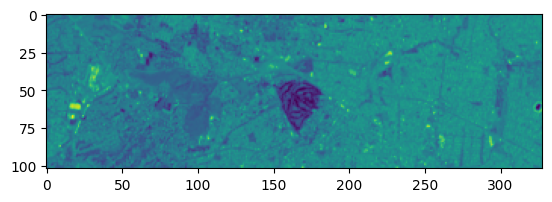

In [ ]:
x_features_n = x_features / 32768
x_features_n = x_features_n.reshape((x_features_n.shape[0], 1, x_features_n.shape[1]))

predicted = model.predict(x_features_n)
print(predicted)
predicted = predicted[:,1] * 255


#Export raster
prediction = np.reshape(predicted, (array_labels.shape[0], array_labels.shape[1]))
#B_img_pred = (prediction).astype('uint8')
B_img_pred = (prediction).astype('float')
plt.imshow(B_img_pred[:,:])
plt.show()

In [ ]:
def loadTiff(in_image, init=None, size_img=None):
    src = raster.read(in_image, bands='all')
    nbands = src.RasterCount
    in_band = src.GetRasterBand(1)  # load one band for size reference
    if init is None:
        xinit,yinit = (0, 0)
    else:
        xinit,yinit = init
    if size_img is None:
        block_xsize, block_ysize = (in_band.XSize, in_band.YSize)
    else:
        block_xsize, block_ysize = size_img

    # read the (multiband) file into an array
    image = src.ReadAsArray(xinit, yinit, block_xsize, block_ysize)
    # reshape from bandsxheightxwidth to wxhxb
    image = np.moveaxis(image, 0, -1)
    return image, block_ysize, block_xsize, nbands

#[img, xsize, ysize, nbands] = loadTiff(os.path.join(drive,image))

In [ ]:
#task_config = {
#    'image': image,
#    'fileFormat': 'GeoTIFF',
#    'folder': 'test_L8_image',
#    'fileNamePrefix': imagename[0:19],
#    'crs': projection,
#    'crsTransform': projection.transform,
#    'description': "clipped area",
#    'scale':20,
#    'region':poly_area
#}


# This is how we order it to start
#task = ee.batch.Export.image.toDrive(**task_config )
#task.start()

### check task status - you can see if it failed, it's running or finished
#task.status()

In [ ]:
#drive = "/content/drive/MyDrive/exercise/"

### loading the file
#s2_data = "test_L8_image"

### loading and checking
#ds1, bands = raster.read(s2_data)
#print(ds1)
#print(bands.shape)